<a href="https://colab.research.google.com/github/JoaoVitorSesma/Predicao-da-Sobrevida-em-Pacientes-com-Cancer-Colorretal-IC/blob/main/Predi%C3%A7%C3%A3o_da_Sobrevida_em_Pacientes_com_C%C3%A2ncer_Colorretal_COX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
  <img src="https://github.com/JoaoVitorSesma/Predicao-da-Sobrevida-em-Pacientes-com-Cancer-Colorretal-IC/blob/main/Figuras/COX.png?raw=true?" width="2560">
</div>


## <font color=#FFB90F>**Importações**

São feitas as importações de bibliotecas necessárias para manipulação de dados, visualização gráfica e modelagem de sobrevivência, além de realizar configurações para o ambiente de trabalho. Primeiramente, são instaladas as bibliotecas scikit-survival, lifelines e seaborn para suportar análises e visualizações de dados de sobrevivência. Em seguida, pandas e numpy são importados para manipulação de dados, enquanto matplotlib e seaborn são utilizados para criar visualizações. As funcionalidades de pré-processamento são suportadas por classes e métodos da scikit-survival e do sklearn, incluindo OneHotEncoder, StandardScaler, e pipelines, que são úteis para preparação e normalização dos dados. Finalmente, o set_config configura o scikit-learn para exibir estimadores em formato de texto, facilitando a interpretação dos modelos.

In [1]:
!pip install scikit-survival --quiet
!pip install lifelines --quiet
!pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.4 MB/s eta 0:00:00


In [2]:
# Manipulação do Banco de Dados
import pandas as pd
import numpy as np

# Visualização Gráfica
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Pré-Processamento
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn import set_config

# Configura o scikit-learn para exibir os estimadores em formato de texto
set_config(display="text")

## <font color=#FFB90F>**Preparação dos Dados**

Na preparação dos dados para o modelo de Cox, foram aplicados filtros para selecionar casos relevantes, como pacientes com diagnósticos colorretais confirmados e idade acima de 19 anos. Além disso, ajustamos as colunas para extrair informações essenciais e calcular intervalos entre eventos, como consulta, diagnóstico e tratamento. Variáveis categóricas foram criadas para facilitar a análise desses intervalos, enquanto colunas irrelevantes ou com muitos valores nulos foram removidas. No ajuste final, convertemos o tempo de sobrevida em meses, além de ajustarmos o tempo até no máximo 5 anos e criamos variáveis binárias para indicar óbitos, garantindo um conjunto de dados consistente para análise de sobrevivência.

In [3]:
def data_preparing(df):
    """
    Descrição:
      Prepara o conjunto de dados para análise, aplicando filtros e transformações.

    Parâmetros:
      df: pandas.DataFrame
        O conjunto de dados que será preparado.

    Retorno:
      pandas.DataFrame
        O conjunto de dados após as transformações.
    """

    # Cópia do DataFrame original
    df_aux = df.copy()

    # SELEÇÕES:
    ## Seleção 1 - Topografia Colorretal (C18, C19, C20)
    df_aux = df_aux[df_aux.TOPOGRUP.isin(['C18', 'C19', 'C20'])]

    ## Seleção 2 - Residentes de SP
    df_aux = df_aux[df_aux.UFRESID == 'SP']

    ## Seleção 3 - Casos com confirmação microscópica
    df_aux = df_aux[df_aux.BASEDIAG == 3]

    ## Seleção 4 - ECGRUP's = I, II, III, IV
    df_aux = df_aux[df_aux.ECGRUP.isin(['I', 'II', 'III', 'IV'])]

    ## Seleção 5 - Casos com morfologia 81403
    df_aux = df_aux[df_aux.MORFO == 81403]

    ## Seleção 6 - ANODIAG até 2020 (ERRATA)
    df_aux = df_aux[~(df_aux.ANODIAG > 2020)]

    ## Seleção 7 - Idade maior que 19
    df_aux = df_aux[df_aux.IDADE > 19]



    # AJUSTES DE COLUNAS:
    ## Dividir a coluna DRS para obter apenas o número da DRS
    DRS_expand = df_aux.DRS.str.split(' ', expand=True)
    df_aux['nDRS'] = DRS_expand[1].astype(int)


    ## Ajuste 2 - RECALCULAR VARIÁVEIS
    ### Ajuste 2.1 - Converter as colunas de data para o formato datetime
    list_datas = ['DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTULTINFO']
    for col_data in list_datas:
        df_aux[col_data] = pd.to_datetime(df_aux[col_data])

    ### Ajuste 2.2 - Calcular a diferença entre as datas para criar novas variáveis
    df_aux['CONSDIAG'] = (df_aux.DTDIAG - df_aux.DTCONSULT).dt.days
    df_aux['DIAGTRAT'] = (df_aux.DTTRAT - df_aux.DTDIAG).dt.days
    df_aux['TRATCONS'] = (df_aux.DTTRAT - df_aux.DTCONSULT).dt.days
    df_aux['ULTIDIAG'] = (df_aux.DTULTINFO - df_aux.DTDIAG).dt.days

    ### Ajuste 2.3 - Preencher os valores NaN com -1
    df_aux.fillna({'CONSDIAG': -1}, inplace=True)
    df_aux.fillna({'DIAGTRAT': -1}, inplace=True)
    df_aux.fillna({'TRATCONS': -1}, inplace=True)

    ### Ajuste 2.4 - Implementar a categorização das variáveis calculadas
    df_aux['CONSDIAG_CAT'] = [0 if consdiag <= 30 else 1 if consdiag <= 60 else 2 for consdiag in df_aux.CONSDIAG]
    df_aux['TRATCONS_CAT'] = [3 if tratcons < 0 else 0 if tratcons <= 60 else 1 if tratcons <= 90 else 2 for tratcons in df_aux.TRATCONS]
    df_aux['DIAGTRAT_CAT'] = [3 if diagtrat < 0 else 0 if diagtrat <= 60 else 1 if diagtrat <= 90 else 2 for diagtrat in df_aux.DIAGTRAT]



    # CRIAÇÃO DE COLUNAS
    ## Criação 1 - Coluna de tempo (úlima informação menos o diagnóstico)
    df_aux['ULTIDIAG'] = (df_aux.DTULTINFO - df_aux.DTDIAG).dt.days

    ## Criação 2 - Coluna para presença metástica
    df_aux['PRESENCA_META'] = 0
    df_aux.loc[df_aux.META01.notnull(), 'PRESENCA_META'] = 1

    ## Criação 3 - Coluna para presença de recidiva
    df_aux['PRESENCA_REC'] = 0
    df_aux.loc[df_aux.REC01.notnull(), 'PRESENCA_REC'] = 1



    # COLUNAS A SEREM REMOVIDAS (Remoções do estudo anterior + novas remoções)
    ## TMO - Possui excesso de valores nulos
    ## TOPOGRUP - Grupo da Topografia (similar a TOPO)
    ## ECGRUP - Grupo do Estagiamento (similar a EC)
    ## IBGE, IBGEATEN, ANODIAG, DIAGTRAT - Colunas com alto grau de variancia
    drop_cols = ['UFNASC', 'UFRESID', 'CIDADE', 'DTCONSULT', 'CLINICA', 'DTDIAG',
                 'BASEDIAG', 'DESCTOPO', 'MORFO', 'DESCMORFO', 'T', 'N', 'M',
                 'PT', 'PN', 'PM', 'S', 'G', 'LOCALTNM', 'IDMITOTIC', 'PSA',
                 'GLEASON', 'OUTRACLA', 'META01', 'META02', 'META03', 'META04',
                 'DTTRAT', 'NAOTRAT', 'TRATAMENTO', 'TRATHOSP', 'TRATFANTES',
                 'TRATFAPOS', 'NENHUMANT', 'CIRURANT', 'RADIOANT', 'QUIMIOANT',
                 'HORMOANT', 'TMOANT', 'IMUNOANT', 'OUTROANT', 'NENHUMAPOS',
                 'CIRURAPOS', 'RADIOAPOS', 'QUIMIOAPOS', 'HORMOAPOS', 'TMOAPOS',
                 'IMUNOAPOS', 'OUTROAPOS', 'DTULTINFO', 'CICI', 'CICIGRUP',
                 'CICISUBGRU', 'FAIXAETAR', 'LATERALI', 'INSTORIG', 'PERDASEG',
                 'ERRO', 'DTRECIDIVA', 'RECNENHUM', 'RECLOCAL', 'RECREGIO',
                 'RECDIST', 'REC01', 'REC02', 'REC03', 'REC04', 'CIDO',
                 'DSCCIDO', 'HABILIT', 'HABIT11', 'HABILIT1', 'CIDADEH', 'DRS',
                 'TMO', 'TOPOGRUP', 'ECGRUP', 'IBGE', 'IBGEATEN', 'ANODIAG', 'DIAGTRAT']



    # Seleção final das colunas do novo DataFrame
    col = df_aux.columns.drop(drop_cols)

    return df_aux[col]

In [4]:
# Banco de dados - Dezembro de 2023
!gdown 1B1qBKob6l-JCOazIko4V6cjK1mIxn2D1 --quiet

In [5]:
# Visualização do Banco de Dados Original
df = pd.read_csv('pacigeral_12_23.csv')
df.head(3)
print(df.shape)

<ipython-input-5-973c422b66cc>:2: DtypeWarning: Columns (23,24,25,32,36,37,73,74,75,78,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pacigeral_12_23.csv')


(1178688, 100)


In [6]:
# Visualização do Banco de Dados Preparado
df_colo = data_preparing(df)
df_colo.head(3)
print(df_colo.shape)

(37500, 26)


In [7]:
# Colunas do novo Data Frame
df_colo.columns

Index(['ESCOLARI', 'IDADE', 'SEXO', 'CATEATEND', 'DIAGPREV', 'TOPO', 'EC',
       'NENHUM', 'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'IMUNO', 'OUTROS',
       'ULTINFO', 'CONSDIAG', 'TRATCONS', 'RRAS', 'HABILIT2', 'nDRS',
       'ULTIDIAG', 'CONSDIAG_CAT', 'TRATCONS_CAT', 'DIAGTRAT_CAT',
       'PRESENCA_META', 'PRESENCA_REC'],
      dtype='object')

In [8]:
def pred_cols(df_colo):

    # Cópia do DataFrame
    df_aux = df_colo.copy()

    # Redefinição dos índices
    df_aux = df_aux.reset_index(drop=True)

    # Eliminação das linhas onde 'ULTIDIAG' é menor que zero
    df_aux = df_aux[df_aux.ULTIDIAG >= 0]

    # Ajuste da coluna 'ULTIDIAG' de dias para meses, arredondando para o valor mais próximo
    df_aux['time'] = (df_aux['ULTIDIAG'] / 30).round()

    # Limitando os valores até no máximo 60 meses (ajustar até 5 anos)
    df_aux['time'] = df_aux['time'].apply(lambda x: 60 if x > 60 else x)

    # Transformação a coluna 'time' com valores = 0 para valores = 1 (ajudar na convergência do modelo)
    df_aux['time'] = df_aux['time'].replace(0, 1)

    # Eliminação a coluna 'ULTIDIAG' (agora transformada para 'time')
    df_aux = df_aux.drop('ULTIDIAG', axis=1)


    # Ajuste da coluna 'ULTINFO' para ser binária (1 = morte / 0 = vivo)
    df_aux['event'] = df_aux['ULTINFO'].apply(lambda x: 1 if x in [3, 4] else 0)

    # Eliminar a coluna 'ULTINFO' (agora transformada para 'event')
    df_aux = df_aux.drop('ULTINFO', axis=1)

    return df_aux

In [9]:
# Ajustes das variáveis preditas
df_colo = pred_cols(df_colo)

In [10]:
# Visualização das colunas com o evento
df_colo['event'].value_counts()

,count
event,
1,22078
0,15421


In [11]:
# Visualização da coluna de evento
df_colo['time'].value_counts().sort_index()

,count
time,
1.0,2159
2.0,1160
3.0,983
4.0,898
5.0,757
6.0,717
7.0,617
8.0,642
9.0,618


In [12]:
# Valores censurados
censored_count = df_colo['event'].value_counts()[0]
print(f"Número de valores censurados: {censored_count}")

Número de valores censurados: 15421


## <font color=#FFB90F>**Codificação das Colunas**

Esse tópico descreve o processo de Codificação das Colunas, onde dados categóricos são transformados em formatos numéricos para permitir sua utilização em modelos de machine learning. Utilizamos dois métodos principais: OneHotEncoder e OrdinalEncoder, ambos da biblioteca sklearn.preprocessing. A função one_hot_encoding aplica OneHotEncoder para codificar colunas especificadas, criando novas colunas binárias que representam cada categoria e evitando multicolinearidade ao descartar a primeira categoria. Em seguida, OrdinalEncoder é utilizado para codificar a coluna EC, transformando categorias em valores inteiros ordenados, com valores desconhecidos recebendo o código -1. Após a aplicação da codificação, são exibidas as colunas originais e codificadas para comparação, assim como as dimensões dos DataFrames antes e depois da codificação, o que ajuda a verificar a integridade e a estrutura dos dados processados.

In [13]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, columns):
    """
    Descrição:
      Aplica OneHotEncoder em colunas específicas de um DataFrame.

    Parâmetros:
      df (pd.DataFrame): DataFrame original a ser transformado.
      columns (list): Lista de colunas categóricas para aplicar OneHotEncoder.

    Retorna:
      df_aux (pd.DataFrame): DataFrame transformado com colunas codificadas e originais removidas.
    """

    # Cópia do DataFrame original
    df_aux = df.copy()

    # Configuração do OneHotEncoder
    ohe = OneHotEncoder(
                handle_unknown='ignore',  # Ignora categorias desconhecidas
                drop='first')             # Evita multicolinearidade

    # Iterar pelas colunas fornecidas
    for col in columns:
        # Aplicar o OneHotEncoder para a coluna
        ohe_results = ohe.fit_transform(df_aux[[col]])

        # Criar um DataFrame com os resultados da codificação OneHot
        ohe_df = pd.DataFrame(
                        ohe_results.toarray(),                     # Codificação para um array
                        columns=ohe.get_feature_names_out([col]),  # Nome das colunas codificadas
                        index=df_aux.index)                        # Mantém os índices

        # Concatenar o DataFrame original com as colunas codificadas
        df_aux = pd.concat([df_aux, ohe_df], axis=1)

        # Remover a coluna original, pois ela foi codificada
        df_aux.drop(columns=[col], inplace=True)

    return df_aux

In [14]:
from sklearn.preprocessing import OrdinalEncoder

# Configurações do Ordinal Encode
oe = OrdinalEncoder(
            handle_unknown='use_encoded_value', # Define como lidar com valores desconhecidos; OBS: O 'use_encoded_value' permite definir um valor específico
            unknown_value=-1) # define que valores desconhecidos serão codificados como -1

# Ajusta o encoder para os dados da coluna 'EC'
oe.fit(df_colo[['EC']])

# Transforma a coluna 'EC' usando o OrdinalEncoder
df_colo[['EC']] = oe.transform(df_colo[['EC']])

In [15]:
# Colunas categóricas
categoric_col = ['TOPO']

# Aplicação do OneHotEncoder
Xt = one_hot_encoding(df_colo, categoric_col)

In [16]:
# Comparação das Colunas
## Colunas originais vs Colunas codificadas
print("Colunas Originais:")
display(df_colo.columns)

print("\nColunas após OneHotEncoder:")
display(Xt.columns)

Colunas Originais:


Index(['ESCOLARI', 'IDADE', 'SEXO', 'CATEATEND', 'DIAGPREV', 'TOPO', 'EC',
       'NENHUM', 'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'RRAS', 'HABILIT2', 'nDRS', 'CONSDIAG_CAT',
       'TRATCONS_CAT', 'DIAGTRAT_CAT', 'PRESENCA_META', 'PRESENCA_REC', 'time',
       'event'],
      dtype='object')


Colunas após OneHotEncoder:


Index(['ESCOLARI', 'IDADE', 'SEXO', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'RRAS', 'HABILIT2', 'nDRS', 'CONSDIAG_CAT',
       'TRATCONS_CAT', 'DIAGTRAT_CAT', 'PRESENCA_META', 'PRESENCA_REC', 'time',
       'event', 'TOPO_C181', 'TOPO_C182', 'TOPO_C183', 'TOPO_C184',
       'TOPO_C185', 'TOPO_C186', 'TOPO_C187', 'TOPO_C188', 'TOPO_C189',
       'TOPO_C199', 'TOPO_C209'],
      dtype='object')

In [17]:
# Comparação dos Formatos
## Tamanho original vs Tamanho codificado
print("Formato do DataFrame Original:")
display(df_colo.shape)

print("\nFormato do DataFrame após OneHotEncoder:")
display(Xt.shape)

Formato do DataFrame Original:


(37499, 26)


Formato do DataFrame após OneHotEncoder:


(37499, 36)

In [18]:
# Comparação dos DataFrames
## DataFrame original vs DataFrame codificado
print("DataFrame Original:")
display(df_colo.head())

print("\nDataFrame após OneHotEncoder:")
display(Xt.head())

DataFrame Original:


,ESCOLARI,IDADE,SEXO,CATEATEND,DIAGPREV,TOPO,EC,NENHUM,CIRURGIA,RADIO,...,RRAS,HABILIT2,nDRS,CONSDIAG_CAT,TRATCONS_CAT,DIAGTRAT_CAT,PRESENCA_META,PRESENCA_REC,time,event
0,9,79,1,9,1,C199,7.0,0,1,0,...,7,1,4,0,2,2,0,0,29.0,1
1,9,68,2,9,1,C180,2.0,0,1,0,...,7,1,4,0,2,2,0,0,50.0,1
2,9,58,2,9,1,C189,2.0,0,1,0,...,7,1,4,0,0,0,0,0,47.0,0
3,9,52,2,9,1,C189,2.0,0,1,0,...,7,1,4,0,2,2,0,0,15.0,1
4,9,62,2,2,1,C180,3.0,0,1,1,...,7,1,4,0,2,2,0,0,9.0,1



DataFrame após OneHotEncoder:


,ESCOLARI,IDADE,SEXO,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,TOPO_C182,TOPO_C183,TOPO_C184,TOPO_C185,TOPO_C186,TOPO_C187,TOPO_C188,TOPO_C189,TOPO_C199,TOPO_C209
0,9,79,1,9,1,7.0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,9,68,2,9,1,2.0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,58,2,9,1,2.0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9,52,2,9,1,2.0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,9,62,2,2,1,3.0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <font color=#FFB90F>**FIT**

 O FIT do modelo de Cox foi aplicado usando a biblioteca lifelines para modelagem de dados de sobrevivência. Primeiramente, é configurado o CoxPHFitter com baseline_estimation_method="spline" e n_baseline_knots=3, para estimar a linha de base com splines, oferecendo flexibilidade na curva de risco. Uma linha do tempo (timeline) é definida para garantir que as previsões de sobrevivência sejam feitas em intervalos regulares, entre o menor e o maior valor de time, com 100 pontos. O modelo é então ajustado (fit) aos dados, utilizando as colunas time (tempo de sobrevivência) e event (indicador de ocorrência do evento). Após o ajuste, é aplicada a survival_probability_calibration para calibrar as previsões de probabilidade de sobrevivência em t0=60, permitindo avaliar a precisão das previsões. Por fim, o print_summary exibe um resumo detalhado do modelo ajustado, incluindo coeficientes e métricas de ajuste.

/usr/local/lib/python3.10/dist-packages/lifelines/calibration.py:45: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.01643613760271761
E50 =  0.017275290577957403


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 60 mortality'}, xlabel='Predicted probability of \nt ≤ 60 mortality', ylabel='Observed probability of \nt ≤ 60 mortality'>,
 0.01643613760271761,
 0.017275290577957403)

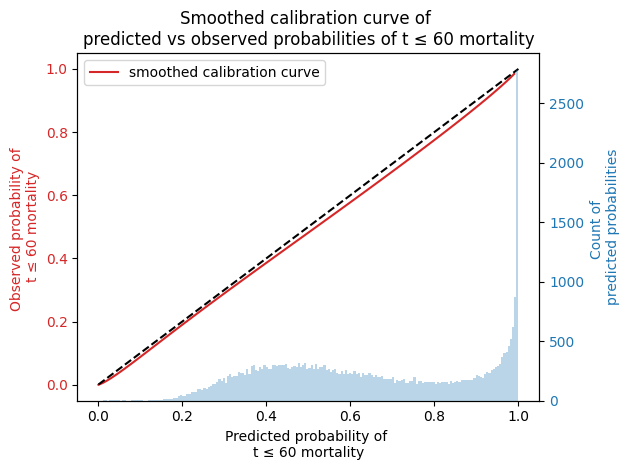

In [19]:
from lifelines import CoxPHFitter
from lifelines.calibration import survival_probability_calibration

# Configuração do ajuste do modelo
cph = CoxPHFitter(
            baseline_estimation_method="spline",  # Define o método de estimativa da linha de base como spline, para maior flexibilidade
            n_baseline_knots=3)                   # Número de nós (knots) para a spline, aumentando a suavidade da linha de base

# Define uma linha do tempo entre o tempo mínimo e o máximo dos eventos, com 100 pontos
timeline = np.linspace(Xt['time'].min(), Xt['time'].max(), 100)

# Ajusta o modelo CoxPHFitter aos dados
cph.fit(
      Xt,                 # DataFrame
      'time',             # Coluna de tempo de sobrevivência
      'event',            # Coluna de evento do paciente
      timeline=timeline)

# Aplicando a calibração de probabilidade de sobrevivência para o modelo ajustado
survival_probability_calibration(
                                cph,   # Modelo CoxPHFitter ajustado
                                Xt,    # Banco de Dados
                                t0=60) # Tempo alvo de sobrevivência para calibração

In [20]:
# Exibir o sumário do modelo ajustado
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 37499 total observations, 15421 right-censored observations>
             duration col = 'time'
                event col = 'event'
 number of baseline knots = 3
      baseline estimation = spline
   number of observations = 37499
number of events observed = 22078
           log-likelihood = -102040.35
         time fit was run = 2024-11-23 17:48:46 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param covariate                                                                                                      
beta_ ESCOLARI      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
      IDADE          0.02      1.02      0.00            0.01            0.02                1.01                1.02
      SEXO          -0.12      0.88      0.01           -0.15           -0.10                0.86                0.91
      CATEATEND      0.06      1.06      0.00            0.05            0.06                1.06                1.06
      DIAGPREV      -0.29      0.75      0.02           -0.32           -0.26                0.72                0.77
      EC             0.11      1.12      0.00            0.11            0.12                1.11                1.13
      NENHUM         0.55      1.74      0.04            0.47            0.64                1.59                1.90
      CIRURGIA      -0.60      0.55      0.02           -0.64           -0.57                0.53                0.57
      RADIO          0.06      1.06      0.02            0.02            0.09                1.02                1.10
      QUIMIO        -0.54      0.58      0.02           -0.57           -0.50                0.56                0.60
      HORMONIO      -0.43      0.65      0.09           -0.60           -0.26                0.55                0.77
      IMUNO         -0.13      0.88      0.16           -0.45            0.20                0.64                1.22
      OUTROS        -0.28      0.75      0.03           -0.34           -0.23                0.71                0.79
      CONSDIAG       0.00      1.00      0.00            0.00            0.00                1.00                1.00
      TRATCONS      -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
      RRAS          -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
      HABILIT2      -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
      nDRS           0.00      1.00      0.00           -0.00            0.01                1.00                1.01
      CONSDIAG_CAT  -0.12      0.89      0.02           -0.15           -0.08                0.86                0.92
      TRATCONS_CAT   0.05      1.05      0.01            0.02            0.08                1.02                1.08
      DIAGTRAT_CAT  -0.06      0.94      0.01           -0.09           -0.04                0.92                0.96
      PRESENCA_META  0.78      2.17      0.02            0.73            0.82                2.08                2.27
      PRESENCA_REC   0.13      1.14      0.02            0.09            0.16                1.10                1.18
      TOPO_C181     -0.40      0.67      0.19           -0.78           -0.02                0.46                0.98
      TOPO_C182      0.01      1.01      0.05           -0.08            0.10                0.92                1.11
      TOPO_C183      0.18      1.20      0.08            0.02            0.34                1.02                1.41
      TOPO_C184      0.08      1.08      0.05           -0.02            0.19                0.98                1.21
      TOPO_C185      0.25      1.28      0.09            0.08            0.42                1.08                1.52
      TOPO_C186     -0.09      0.92      0.05           -0.19  

## <font color=#FFB90F>**C-Índex**

O cálculo do Índice de Concordância (C-Index) mede a capacidade do modelo de Cox ajustado em ordenar corretamente as previsões de sobrevivência. Esse índice avalia a discriminação do modelo, ou seja, sua habilidade de prever se, para dois indivíduos, aquele com o maior risco estimado terá o evento antes do outro. O valor do C-Index varia entre 0 e 1, onde valores mais próximos de 1 indicam uma maior precisão nas previsões do modelo. No código, cph.score é utilizado com o parâmetro scoring_method='concordance_index' para calcular o C-Index, e o resultado é exibido, permitindo avaliar a performance do modelo ajustado em ordenar corretamente os tempos de sobrevivência.

In [21]:
# Calcula o índice de concordância (concordance index) do modelo ajustado
concordance_index = cph.score(Xt, scoring_method='concordance_index')
print(f'Concordance Index: {concordance_index}')

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2371: ApproximationWarning: Approximating using `predict_survival_function`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(


Concordance Index: 0.747253046088436


## <font color=#FFB90F>**P-Values**





A seleção de variáveis significativas foi feita com base nos p-values para melhorar a interpretação e potencialmente o desempenho do modelo de Cox. Primeiramente, é definida uma função ajuste_modelo_significativo que filtra as variáveis do modelo original com p-values abaixo de um limite especificado (0.05 por padrão), mantendo apenas as variáveis estatisticamente significativas. O modelo de Cox inicial é ajustado com todas as variáveis (cph_original), e as variáveis com significância são selecionadas a partir do sumário do modelo. Com isso, um segundo modelo (cph_significativo) é ajustado usando apenas essas variáveis significativas, utilizando uma spline com 4 nós para uma linha de base mais flexível. Ambos os modelos são comparados em termos de C-Index, para avaliar qual tem melhor discriminação. Além disso, as colunas removidas são identificadas, permitindo uma visão das variáveis que não contribuem de forma significativa. Por fim, o modelo simples (cph_simples) é ajustado novamente para exibir os coeficientes e suas distribuições, auxiliando na análise dos efeitos de cada variável no tempo de sobrevivência.

In [22]:
def ajuste_modelo_significativo(cph_summary, Xt, p_val_threshold=0.05):
    """
    Descrição:
      Filtra as variáveis significativas com p-value menor que o threshold fornecido.

    Parâmetros:
      cph_summary (pd.DataFrame): Sumário do CoxPHFitter contendo p-values.
      Xt (pd.DataFrame): Conjunto de dados com variáveis independentes e colunas de tempo/evento.
      p_val_threshold (float): Limite de corte para significância estatística (p-value).

    Retorna:
      Xt_significativos (pd.DataFrame): Conjunto de dados com apenas as variáveis significativas.
    """
    # Cria uma cópia do Xt original
    Xt_copia = Xt.copy()

    # Seleciona os índices das variáveis que possuem p-value abaixo do threshold, excluindo o 'Intercept'
    indices_significativos = cph_summary[
        (cph_summary['p'] < p_val_threshold) & (cph_summary.index.get_level_values(1) != 'Intercept')
    ].index.get_level_values(1)

    # Inclui apenas as variáveis significativas
    Xt_significativos = Xt_copia[indices_significativos]

    # Adiciona as colunas 'days' e 'event' de volta ao DataFrame filtrado
    Xt_significativos = pd.concat([Xt_significativos, Xt_copia[['time', 'event']]], axis=1)

    return Xt_significativos

/usr/local/lib/python3.10/dist-packages/lifelines/calibration.py:45: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.01643613760271761
E50 =  0.017275290577957403


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 60 mortality'}, xlabel='Predicted probability of \nt ≤ 60 mortality', ylabel='Observed probability of \nt ≤ 60 mortality'>,
 0.01643613760271761,
 0.017275290577957403)

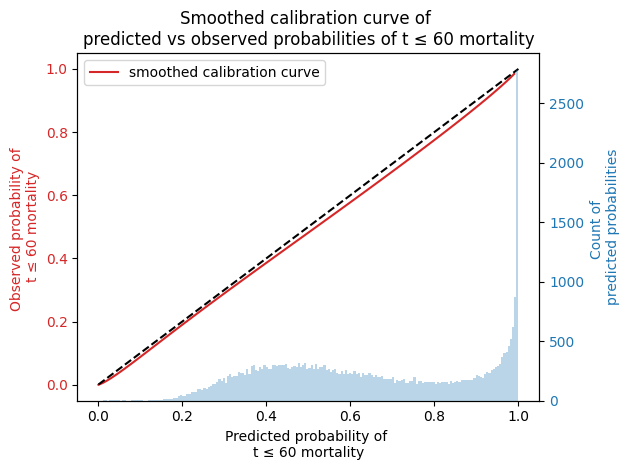

In [23]:
# Ajuste do modelo com Todas as variáveis
cph_original = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)
cph_original.fit(Xt, duration_col='time', event_col='event')

# Aplicando a calibração de probabilidade de sobrevivência
# O t0 é o tempo de sobrevivência que você deseja analisar como 60 meses.
survival_probability_calibration(cph_original, Xt, t0=60)

/usr/local/lib/python3.10/dist-packages/lifelines/calibration.py:45: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.01643613760271761
E50 =  0.017275290577957403


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 60 mortality'}, xlabel='Predicted probability of \nt ≤ 60 mortality', ylabel='Observed probability of \nt ≤ 60 mortality'>,
 0.01643613760271761,
 0.017275290577957403)

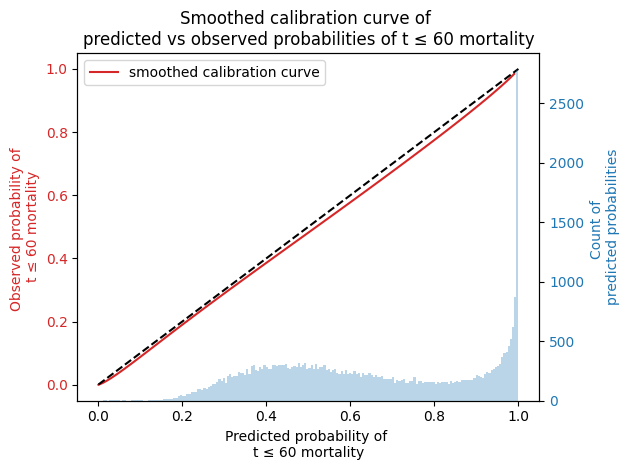

In [24]:
from lifelines import CoxPHFitter
from lifelines.calibration import survival_probability_calibration

# Configuração do ajuste do modelo (3 knots)
cph = CoxPHFitter(
            baseline_estimation_method="spline",  # Define o método de estimativa da linha de base como spline, para maior flexibilidade
            n_baseline_knots=3)                   # Número de nós (knots) para a spline, aumentando a suavidade da linha de base

# Define uma linha do tempo entre o tempo mínimo e o máximo dos eventos, com 100 pontos
timeline = np.linspace(Xt['time'].min(), Xt['time'].max(), 100)

# Ajusta o modelo CoxPHFitter aos dados
cph.fit(
      Xt,                 # DataFrame
      'time',             # Coluna de tempo de sobrevivência
      'event',            # Coluna de evento do paciente
      timeline=timeline)

# Aplicando a calibração de probabilidade de sobrevivência para o modelo ajustado
survival_probability_calibration(
                                cph,   # Modelo CoxPHFitter ajustado
                                Xt,    # Banco de Dados
                                t0=60) # Tempo alvo de sobrevivência para calibração

/usr/local/lib/python3.10/dist-packages/lifelines/calibration.py:45: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.018049497087408446
E50 =  0.020723559018049342


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 60 mortality'}, xlabel='Predicted probability of \nt ≤ 60 mortality', ylabel='Observed probability of \nt ≤ 60 mortality'>,
 0.018049497087408446,
 0.020723559018049342)

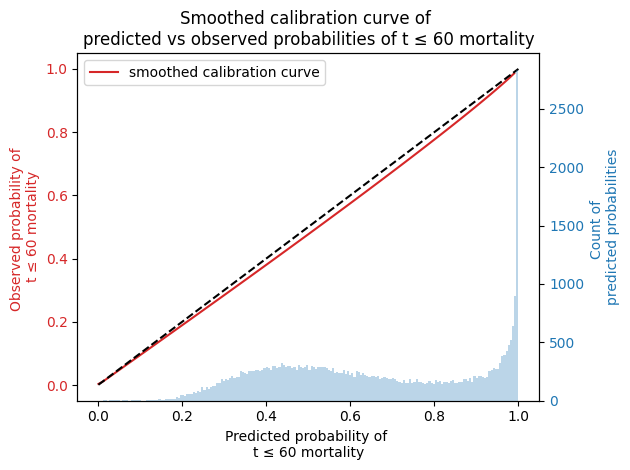

In [25]:
# Filtrar as variáveis significativas com p-value < 0.05
Xt_significativos = ajuste_modelo_significativo(cph_original.summary, Xt)

# Configuração do ajuste do modelo (4knots)
cph_significativo = CoxPHFitter(
                          baseline_estimation_method="spline",  # Define o método de estimativa da linha de base como spline, para maior flexibilidade
                          n_baseline_knots=4)                   # Número de nós (knots) para a spline, aumentando a suavidade da linha de base

# Define uma linha do tempo entre o tempo mínimo e o máximo dos eventos, com 100 pontos
timeline = np.linspace(Xt_significativos['time'].min(), Xt_significativos['time'].max(), 100)

# Ajusta o modelo CoxPHFitter aos dados
cph_significativo.fit(
                    Xt_significativos,  # DataFrame
                    'time',             # Coluna de tempo de sobrevivência
                    'event',            # Coluna de evento do paciente
                    timeline=timeline)

# Aplicando a calibração de probabilidade de sobrevivência para o modelo ajustado
survival_probability_calibration(
                            cph_significativo, # Modelo CoxPHFitter ajustado
                            Xt_significativos, # Banco de Dados
                            t0=60)             # Tempo alvo de sobrevivência para calibração

In [26]:
# Comparação dos C-index
c_index_original = cph_original.score(Xt, scoring_method='concordance_index')
c_index_significativo = cph_significativo.score(Xt_significativos, scoring_method='concordance_index')

print(f'C-index para o modelo original: {c_index_original}')
print(f'C-index para o modelo com variáveis significativas: {c_index_significativo}')

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2371: ApproximationWarning: Approximating using `predict_survival_function`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2371: ApproximationWarning: Approximating using `predict_survival_function`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(


C-index para o modelo original: 0.7472345444821444
C-index para o modelo com variáveis significativas: 0.7472923163783578


In [27]:
# Obter as colunas originais (sem 'time' e 'event')
colunas_originais = Xt.columns.drop(['time', 'event'])

# Obter as colunas significativas (sem 'time' e 'event')
colunas_significativas = Xt_significativos.columns.drop(['time', 'event'])

# Identificar as colunas que foram removidas (presentes nas originais, mas não nas significativas)
colunas_removidas = colunas_originais.difference(colunas_significativas)

# Colunas removidas
print("Colunas removidas após a seleção dos p-values:")
display(colunas_removidas)

Colunas removidas após a seleção dos p-values:


Index(['ESCOLARI', 'HABILIT2', 'IMUNO', 'TOPO_C182', 'TOPO_C184', 'TOPO_C186',
       'TOPO_C187', 'TOPO_C188', 'TOPO_C189', 'nDRS'],
      dtype='object')

In [28]:
# Ajuste simples do modelo
cph_simples = CoxPHFitter()
cph_simples.fit(Xt, 'time', 'event')
cph_simples.print_summary()

<lifelines.CoxPHFitter: fitted with 37499 total observations, 15421 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 37499
number of events observed = 22078
   partial log-likelihood = -212055.31
         time fit was run = 2024-11-23 17:49:52 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
ESCOLARI      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
IDADE          0.02      1.02      0.00            0.02            0.02                1.02                1.02
SEXO          -0.13      0.88      0.01           -0.16           -0.10                0.85                0.90
CATEATEND      0.06      1.06      0.00            0.05            0.06                1.06                1.06
DIAGPREV      -0.29      0.74      0.02           -0.33           -0.26                0.72                0.77
EC             0.11      1.12      0.00            0.10            0.12                1.11                1.12
NENHUM         0.55      1.73      0.04            0.46            0.64                1.59                1.89
CIRURGIA      -0.59      0.55      0.02           -0.63           -0.56                0.53                0.57
RADIO          0.06      1.07      0.02            0.03            0.10                1.03                1.11
QUIMIO        -0.53      0.59      0.02           -0.56           -0.49                0.57                0.61
HORMONIO      -0.42      0.66      0.09           -0.59           -0.25                0.56                0.78
IMUNO         -0.10      0.91      0.16           -0.42            0.22                0.66                1.25
OUTROS        -0.27      0.76      0.03           -0.32           -0.22                0.72                0.81
CONSDIAG       0.00      1.00      0.00            0.00            0.00                1.00                1.00
TRATCONS      -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
RRAS          -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
HABILIT2      -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
nDRS           0.00      1.00      0.00           -0.00            0.01                1.00                1.01
CONSDIAG_CAT  -0.11      0.90      0.02           -0.15           -0.07                0.86                0.93
TRATCONS_CAT   0.05      1.05      0.01            0.02            0.07                1.02                1.08
DIAGTRAT_CAT  -0.06      0.94      0.01           -0.08           -0.03                0.92                0.97
PRESENCA_META  0.78      2.18      0.02            0.74            0.83                2.09                2.28
PRESENCA_REC   0.18      1.20      0.02            0.14            0.21                1.15                1.24
TOPO_C181     -0.40      0.67      0.19           -0.78           -0.02                0.46                0.98
TOPO_C182     -0.00      1.00      0.05           -0.10            0.09                0.91                1.09
TOPO_C183      0.17      1.19      0.08            0.01            0.33                1.01                1.39
TOPO_C184      0.07      1.08      0.05           -0.03            0.18                0.97                1.20
TOPO_C185      0.24      1.27      0.09            0.07            0.41                1.07                1.50
TOPO_C186     -0.08      0.92      0.05           -0.18            0.02                0.83                1.02
TOPO_C187     -0.03      0.97      0.04           -0.11            0.06                0.89                1.06
TOPO_C188      0.10      1.10      0.10         

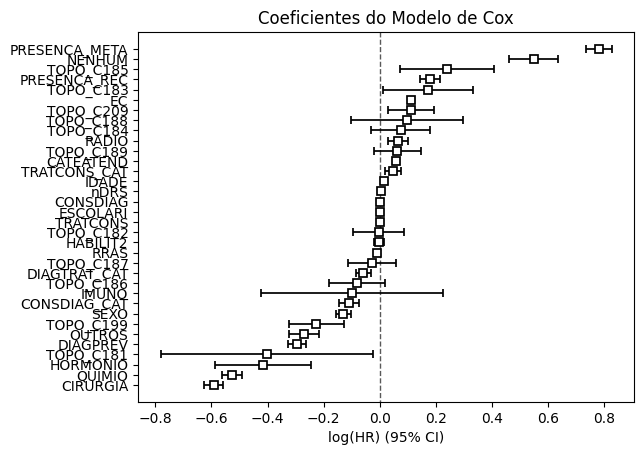

In [29]:
# Coeficientes e suas distibuições
cph_simples.plot()
plt.title("Coeficientes do Modelo de Cox")
plt.show()

## <font color=#FFB90F>**Predição**

Foi realizada a predição de tempo de sobrevivência usando dois modelos de Cox: o modelo original (com todas as variáveis) e o modelo ajustado apenas com variáveis significativas. Primeiramente, o modelo original é ajustado com o conjunto de dados completo (Xt), e em seguida, são geradas previsões do tempo de sobrevivência esperado para cada paciente. As previsões são apresentadas em um DataFrame comparativo, mostrando o tempo real e o tempo previsto de sobrevida. Para entender a amplitude das previsões, são calculados os valores mínimo e máximo de tempo de sobrevida previsto, além das diferenças entre tempos reais e previstos.

Posteriormente, o modelo com variáveis significativas é ajustado com o conjunto de dados filtrado (Xt_significativos). Assim como no modelo original, as previsões são geradas e apresentadas em um DataFrame, comparando os tempos reais e previstos.

Para visualizar a precisão de ambos os modelos, gráficos de dispersão são criados, onde cada ponto representa a relação entre o tempo real e o tempo previsto de sobrevida. A linha vermelha pontilhada representa a linha de referência onde tempo real é igual ao tempo previsto, facilitando a análise de acurácia dos modelos. A figura final permite a comparação entre os modelos original e significativo, ajudando a identificar qual modelo oferece previsões mais próximas dos tempos de sobrevida reais.

### <font color=#FFE4C4>**Modelo Original**

In [30]:
# Ajusta o modelo de Cox Proportional Hazards usando o DataFrame Xt para o modelo original
cph_original = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)
timeline = np.linspace(Xt['time'].min(), Xt['time'].max(), 100)
cph_original.fit(Xt, duration_col='time', event_col='event', timeline=timeline)

# Previsão do tempo de sobrevivência esperado para o modelo original
y_pred_tempo_original = cph_original.predict_expectation(Xt)

# Exibindo as previsões para o modelo original
df_pred_tempo_original = pd.DataFrame({
    'Tempo de Sobrevida Real (time)': Xt['time'],
    'Tempo de Sobrevida Previsto (Modelo Original)': y_pred_tempo_original
})
display(df_pred_tempo_original)

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2507: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)


,Tempo de Sobrevida Real (time),Tempo de Sobrevida Previsto (Modelo Original)
0,29.0,37.617805
1,50.0,44.653872
2,47.0,44.694392
3,15.0,46.915910
4,9.0,48.244380
...,...,...
37495,31.0,47.941655
37496,28.0,45.129956
37497,33.0,54.458481
37498,32.0,48.356172


In [31]:
# prompt: valor min e max de tempo de sobrevida previsto

# Previsão do tempo de sobrevivência esperado para o modelo original
y_pred_tempo_original = cph_original.predict_expectation(Xt)

# Encontrando o valor mínimo e máximo do tempo de sobrevida previsto
min_tempo_previsto = y_pred_tempo_original.min()
max_tempo_previsto = y_pred_tempo_original.max()

print(f"Valor mínimo do tempo de sobrevida previsto: {min_tempo_previsto}")
print(f"Valor máximo do tempo de sobrevida previsto: {max_tempo_previsto}")

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2507: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)


Valor mínimo do tempo de sobrevida previsto: 1.3435233015631558
Valor máximo do tempo de sobrevida previsto: 58.717747481485


In [32]:
# prompt: valor min e max de diferença de meses reais e previstos

# Calculate the difference between predicted and actual survival times
diferenca_meses = Xt['time'] - y_pred_tempo_original

# Find the minimum and maximum difference
min_diferenca = diferenca_meses.min()
max_diferenca = diferenca_meses.max()

print(f"Valor mínimo da diferença entre tempos reais e previstos: {min_diferenca}")
print(f"Valor máximo da diferença entre tempos reais e previstos: {max_diferenca}")

Valor mínimo da diferença entre tempos reais e previstos: -53.02023306260221
Valor máximo da diferença entre tempos reais e previstos: 57.49793656127258


### <font color=#FFE4C4> **Variáveis Significatvas**

In [33]:
# Ajustar o modelo com o conjunto de variáveis significativas
cph_significativo = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)
timeline = np.linspace(Xt['time'].min(), Xt['time'].max(), 100)
cph_significativo.fit(Xt_significativos, duration_col='time', event_col='event',timeline=timeline)

# Previsão do tempo de sobrevivência esperado para o modelo com variáveis significativas
y_pred_tempo_significativo = cph_significativo.predict_expectation(Xt_significativos)

# Exibindo as previsões para o modelo com variáveis significativas
df_pred_tempo_significativo = pd.DataFrame({
    'Tempo de Sobrevida Real (time)': Xt_significativos['time'],
    'Tempo de Sobrevida Previsto (Modelo Significativo)': y_pred_tempo_significativo
})
display(df_pred_tempo_significativo)

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2507: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)


,Tempo de Sobrevida Real (time),Tempo de Sobrevida Previsto (Modelo Significativo)
0,29.0,37.526440
1,50.0,44.477287
2,47.0,45.172841
3,15.0,47.356254
4,9.0,48.172073
...,...,...
37495,31.0,47.761625
37496,28.0,45.087570
37497,33.0,54.375683
37498,32.0,47.933770


### <font color=#FFE4C4> **Comparação/Pacientes específicos (Gráficos)**

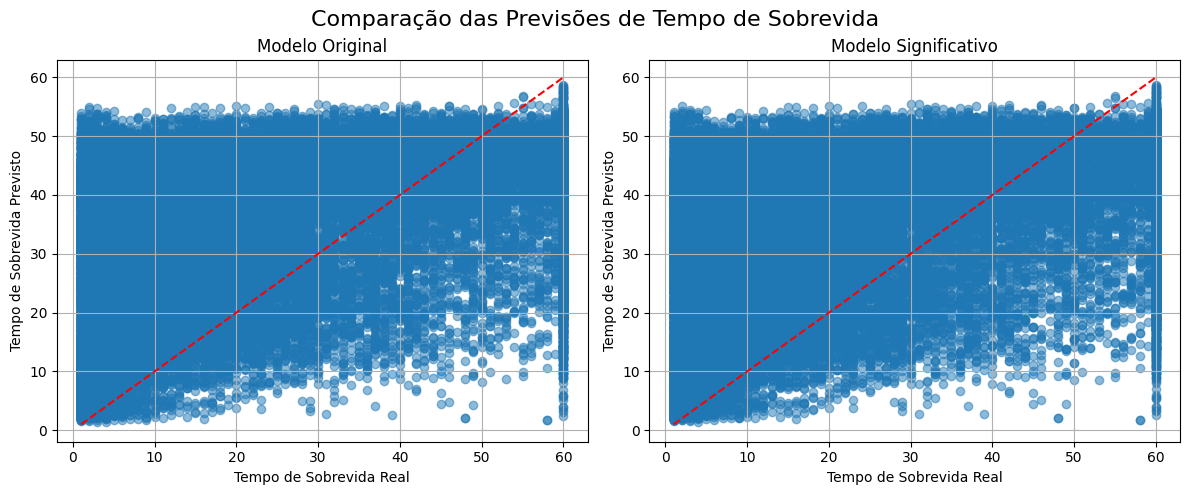

In [34]:
# Ajustando os DataFrames para ter os nomes corretos das colunas
df_pred_tempo_original.columns = ['Tempo de Sobrevida Real', 'Tempo de Sobrevida Previsto (Original)']
df_pred_tempo_significativo.columns = ['Tempo de Sobrevida Real', 'Tempo de Sobrevida Previsto (Significativo)']

# Configura a figura para visualização
plt.figure(figsize=(12, 5))

# Gráfico para o modelo original
plt.subplot(1, 2, 1)
plt.scatter(df_pred_tempo_original['Tempo de Sobrevida Real'], df_pred_tempo_original['Tempo de Sobrevida Previsto (Original)'], alpha=0.5)
plt.plot([df_pred_tempo_original['Tempo de Sobrevida Real'].min(), df_pred_tempo_original['Tempo de Sobrevida Real'].max()],
         [df_pred_tempo_original['Tempo de Sobrevida Real'].min(), df_pred_tempo_original['Tempo de Sobrevida Real'].max()],
         'r--')
plt.xlabel('Tempo de Sobrevida Real')
plt.ylabel('Tempo de Sobrevida Previsto')
plt.title('Modelo Original')
plt.grid(True)

# Gráfico para o modelo com variáveis significativas
plt.subplot(1, 2, 2)
plt.scatter(df_pred_tempo_significativo['Tempo de Sobrevida Real'], df_pred_tempo_significativo['Tempo de Sobrevida Previsto (Significativo)'], alpha=0.5)
plt.plot([df_pred_tempo_significativo['Tempo de Sobrevida Real'].min(), df_pred_tempo_significativo['Tempo de Sobrevida Real'].max()],
         [df_pred_tempo_significativo['Tempo de Sobrevida Real'].min(), df_pred_tempo_significativo['Tempo de Sobrevida Real'].max()],
         'r--')
plt.xlabel('Tempo de Sobrevida Real')
plt.ylabel('Tempo de Sobrevida Previsto')
plt.title('Modelo Significativo')
plt.grid(True)

# Ajusta o layout e exibe a figura
plt.tight_layout()
plt.suptitle('Comparação das Previsões de Tempo de Sobrevida', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

## <font color=#FFB90F>**Métricas do R²**

Para a avaliação do modelo foi feito um código que calcula e compara diversas métricas de desempenho entre o modelo de Cox original e o modelo ajustado com variáveis significativas. A função calcular_metricas gera o C-Index e outras métricas estatísticas para avaliar a precisão das previsões do modelo. As métricas incluem:

**C-Index:** mede a capacidade do modelo de classificar corretamente os tempos de sobrevivência.

**MSE (Erro Quadrático Médio) e RMSE (Raiz do Erro Quadrático Médio):** indicam o desvio médio das previsões em relação aos valores reais.

**MAE (Erro Médio Absoluto):** mede o desvio absoluto médio entre as previsões e os valores reais.

**MAPE (Erro Médio Absoluto Percentual):** mostra o erro médio percentual das previsões.

**R²:** indica o quão bem as variáveis independentes explicam a variabilidade no tempo de sobrevivência.

Para cada modelo, as previsões são feitas usando predict_expectation para estimar o tempo de sobrevivência esperado, e as métricas são calculadas com base nas comparações entre os valores reais e previstos. Por fim, uma tabela é gerada para comparar o desempenho entre o modelo original e o modelo com variáveis significativas, facilitando a análise das melhorias ou perdas em precisão entre eles.

In [35]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score

# Função para calcular as métricas de desempenho
def calcular_metricas(y_real, y_pred, modelo, X):

    c_index = modelo.score(X, scoring_method='concordance_index') # Usa o C-Index do método score do CoxPHFitter
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)

    return {'C-Index': c_index, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R²': r2}

In [36]:
# Calculando as métricas para o modelo original
y_pred_original = cph_original.predict_expectation(Xt)
metricas_original = calcular_metricas(Xt['time'], y_pred_original, cph_original, Xt)

# Calculando as métricas para o modelo com variáveis significativas
y_pred_significativo = cph_significativo.predict_expectation(Xt_significativos)
metricas_significativo = calcular_metricas(Xt_significativos['time'], y_pred_significativo, cph_significativo, Xt_significativos)

# DataFrame para comparar as métricas
df_comparacao = pd.DataFrame({
    'Métricas': ['C-Index', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R²'],
    'Modelo Original': [metricas_original['C-Index'], metricas_original['MSE'], metricas_original['RMSE'], metricas_original['MAE'], metricas_original['MAPE'], metricas_original['R²']],
    'Modelo Significativo': [metricas_significativo['C-Index'], metricas_significativo['MSE'], metricas_significativo['RMSE'], metricas_significativo['MAE'], metricas_significativo['MAPE'], metricas_significativo['R²']]
})

# Tabela comparativa
display(df_comparacao)

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2507: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2371: ApproximationWarning: Approximating using `predict_survival_function`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2507: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2371: ApproximationWarning: Approximating using `predict_survival_function`. To increase accuracy, try using or i

,Métricas,Modelo Original,Modelo Significativo
0,C-Index,0.747253,0.746897
1,MSE,380.028383,380.417435
2,RMSE,19.494317,19.504293
3,MAE,16.211168,16.218370
4,MAPE,2.579989,2.582974
5,R²,0.250213,0.249445


from matplotlib import pyplot as plt
df_comparacao['Modelo Original'].plot(kind='hist', bins=20, title='Modelo Original')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_comparacao['Modelo Significativo'].plot(kind='hist', bins=20, title='Modelo Significativo')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_comparacao.groupby('Métricas').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_comparacao.plot(kind='scatter', x='Modelo Original', y='Modelo Significativo', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_comparacao['Modelo Original'].plot(kind='line', figsize=(8, 4), title='Modelo Original')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_comparacao['Modelo Significativo'].plot(kind='line', figsize=(8, 4), title='Modelo Significativo')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_comparacao['Métricas'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_comparacao, x='Modelo Original', y='Métricas', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_comparacao['Métricas'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_comparacao, x='Modelo Significativo', y='Métricas', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# <font color=#FFB90F>**Gráficos**

Neste tópico, foi apresenta uma série de gráficos para análise visual dos resultados do modelo de sobrevivência e da distribuição dos dados.

**Gráfico Comparativo de Previsões vs. Valores Reais:** O primeiro gráfico compara o tempo de sobrevivência real com as previsões do modelo para o conjunto de variáveis significativas (Xt_significativos). Cada ponto representa uma observação, e a linha vermelha pontilhada indica onde os valores reais seriam iguais às previsões. Esse gráfico ajuda a identificar a precisão das previsões em relação aos tempos reais.

**Distribuição dos Resíduos:** O segundo gráfico exibe um histograma com a distribuição dos resíduos, calculados como a diferença entre os tempos reais e as previsões do modelo. O uso do KDE (Kernel Density Estimate) sobreposto fornece uma visão suave da distribuição dos resíduos, permitindo identificar possíveis vieses nas previsões.

**Curva de Sobrevivência de Kaplan-Meier:** O gráfico da curva de Kaplan-Meier é utilizado para visualizar a probabilidade de sobrevivência ao longo do tempo. Esse modelo não-paramétrico é ajustado com os dados de tempo e eventos (Xt), e a curva resultante mostra como a probabilidade de sobrevivência decresce ao longo dos meses.

**Histograma da Distribuição do Tempo de Sobrevivência:** Este gráfico mostra a distribuição dos tempos de sobrevivência ao longo dos 60 meses, com bins específicos para cada mês. A linha KDE sobreposta fornece uma visão suave da densidade dos tempos de sobrevivência, facilitando a análise da distribuição geral e ajudando a identificar padrões temporais.

Esses gráficos combinados oferecem uma visão abrangente da qualidade das previsões do modelo, da distribuição dos resíduos, da probabilidade de sobrevivência ao longo do tempo e da distribuição dos tempos de sobrevivência, auxiliando na avaliação e interpretação dos resultados.

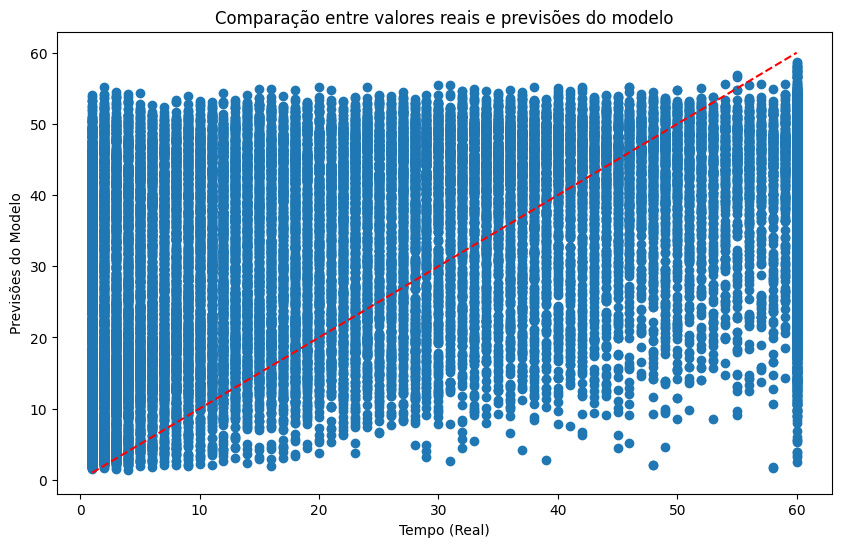

In [37]:
# Gráfico comparativo dos resultados Xt_significativos['time'] e y_pred_significativo
plt.figure(figsize=(10, 6))
plt.scatter(Xt_significativos['time'], y_pred_significativo, alpha=1.0)
plt.xlabel('Tempo (Real)')
plt.ylabel('Previsões do Modelo')
plt.title('Comparação entre valores reais e previsões do modelo')
plt.plot([Xt_significativos['time'].min(), Xt_significativos['time'].max()],
         [Xt_significativos['time'].min(), Xt_significativos['time'].max()],
         color='red', linestyle='--')
plt.show()

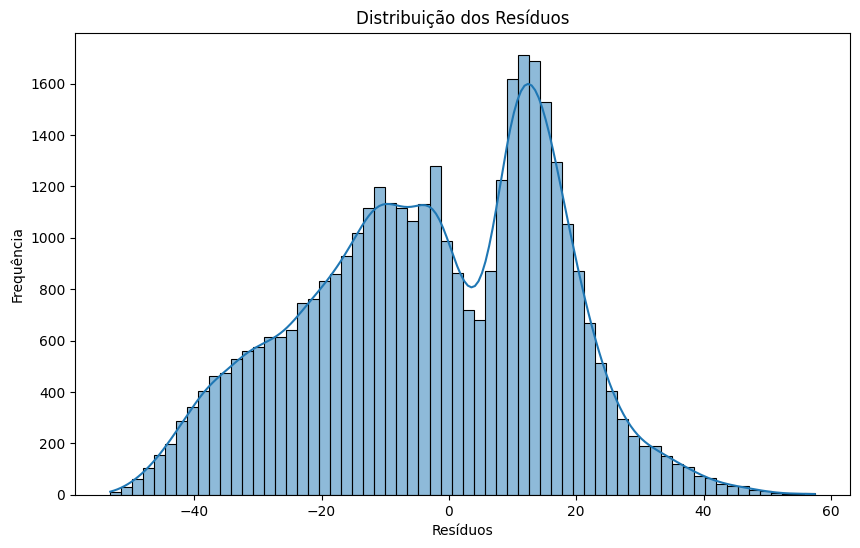

In [38]:
# Gráfico da distribuição dos resíduos de Xt_significativos['time'] e as predições y_pred_significativo
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
residuals = Xt_significativos['time'] - y_pred_significativo
sns.histplot(residuals, kde=True)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')
plt.show()

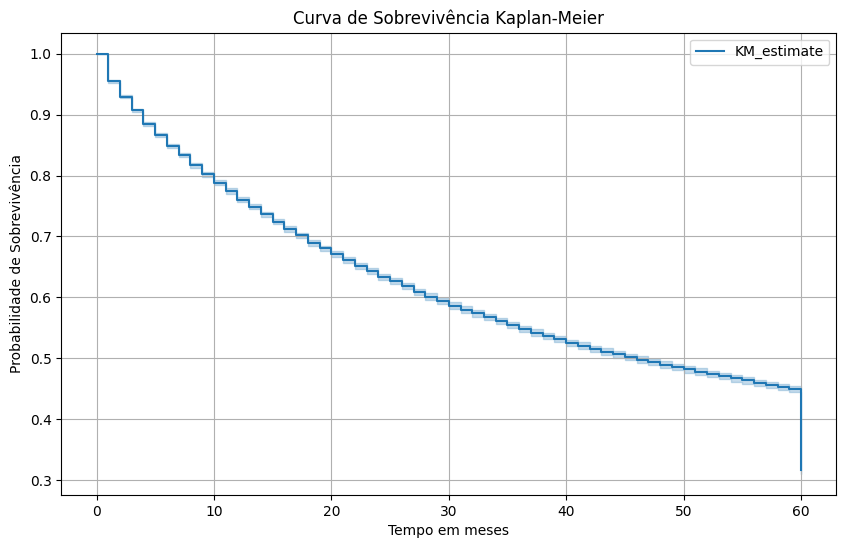

In [39]:
from lifelines import KaplanMeierFitter

# Curva de KaplanMeier
kmf = KaplanMeierFitter()
kmf.fit(Xt['time'], Xt['event'])

# Configura a figura para o gráfico da curva de sobrevivência
plt.figure(figsize=(10,6))

# Cria um gráfico da curva de sobrevivência de Kaplan-Meier
kmf.plot_survival_function()
plt.title('Curva de Sobrevivência Kaplan-Meier')
plt.xlabel('Tempo em meses')
plt.ylabel('Probabilidade de Sobrevivência')
plt.grid(True)
plt.show()

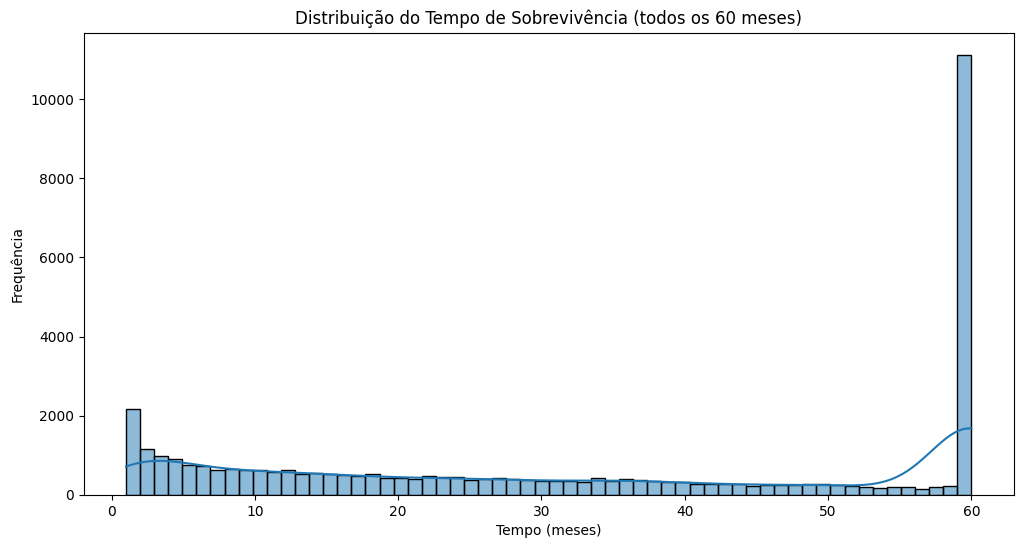

In [40]:
# Histograma da distribuição de 'time' pelos 60 meses
plt.figure(figsize=(12, 6))
sns.histplot(Xt['time'], bins=60, edgecolor='k', kde=True)  # bins=60 para mostrar todos os meses
plt.title('Distribuição do Tempo de Sobrevivência (todos os 60 meses)')
plt.xlabel('Tempo (meses)')
plt.ylabel('Frequência')
plt.show()